Reference :https://www.kaggle.com/philculliton/nlp-getting-started-tutorial

The above reference was used to create this tutorial with additional comparison and improvements added to original documentation.

**Importing Libraries**

We aim to build an application to detect whether the disaster is real or fake depending on the user's tweets. At first we will import all the required libraries at the top.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


**Reading the Dataset**

Here with the help of pandas we will read our training and testing dataset and store accordingly

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test= pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Data Visualization**


we see distribution of real disaster and non-disaster tweet

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


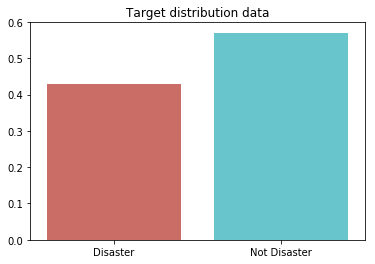

In [3]:
from scipy import stats
train.groupby(['target']).size()
import seaborn as sns
import matplotlib.pyplot as plt
dis = pd.concat([train, test], ignore_index=True)
graph = dis.target.value_counts().values
graph_values = [(graph[1] / sum(graph)),  (graph[0] / sum(graph))]
sns.barplot(x=['Disaster', 'Not Disaster'], y=graph_values, palette="hls").set_title('Target distribution data')
plt.show()

We plot the real Disaster tweets based on location

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


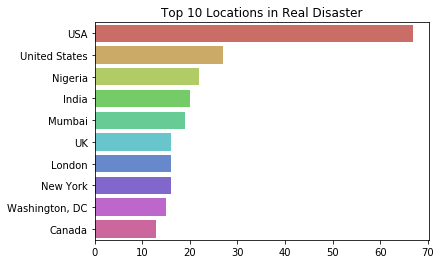

In [4]:
sns.barplot(y=train[dis.target == 1].location.value_counts()[:10].index, 
            x=train[dis.target == 1].location.value_counts()[:10].values,
            palette="hls").set_title('Top 10 Locations in Real Disaster')
plt.show()

We plot the Non-Disaster tweets based on location

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


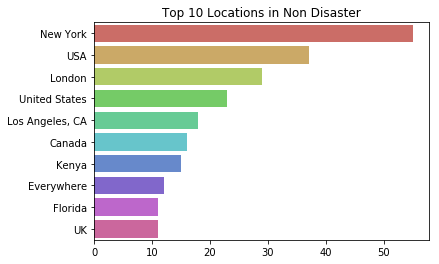

In [5]:
sns.barplot(y=train[dis.target == 0].location.value_counts()[:10].index, 
            x=train[dis.target == 0].location.value_counts()[:10].values,
            palette="hls").set_title('Top 10 Locations in Non Disaster')
plt.show()

**Preprocessing the Tweet before training the data**

**Converting Tweets into Bag of words**

We'll use scikit-learn's CountVectorizer to count the words in each tweet and turn them into data our machine learning model can process.

Note: a vector is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [6]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train["text"][0:5])
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


The above tells us that:

There are 54 unique words (or "tokens") in the first five tweets.
The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.
Now let's create vectors for all of our tweets

In [7]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train["text"])

Now we converted our training dataset into bag of words which will be used as set of features for our classification model to predict whether the disaster tweet is real or fake.

Now lets use Ridge Classification to create our model to predict the disaster.

In [8]:
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use cross-validation - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [9]:
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.59421842, 0.56498283, 0.64113893])

We see our model has accuracy of 65% which is not that great.So let's Try to improve that. Instead of using CountVectorizer we will use TFidf vectorizer to create our bag of words. 

TFidf reduces the number of words by checking the importance of words. It only takes those words which add meaning to tweet and help us categorize the tweet.

In [10]:
tfidf_count_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
train_vectors = tfidf_count_vectorizer.fit_transform(train["text"])
test_vectors = tfidf_count_vectorizer.transform(test["text"])

Now we check the accuracy of our new model with the new set of vectors using TFidf

In [11]:
clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.59579306, 0.56336528, 0.67662204])

Here we see that TFidf provides better accuracy. Hence we can say that it is better than CountVectorizer.

Now lets try to train our model with different classification algorithm to see if we can provide any enhancememnt. We will be using Support Vector Machine(SVM) to build our classification model and check its accuracy.

In [12]:
svc = SVC(kernel = 'linear', random_state = 0)
scores = model_selection.cross_val_score(svc, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.59542857, 0.55836471, 0.66458007])

As we can see that svm doesn't provide any enhancement in this case so we do not use it for submission. Hence we fit our testing data using TFidf and Ridge Classifier.

In [13]:
clf.fit(train_vectors, train["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

Now we create our submission.csv file to make the submission for this project.

In [14]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [15]:
sample_submission.to_csv("submission.csv", index=False)